# Fine Calibrations

The amplitude of a pulse can be precisely calibrated using error amplifying gate sequences. These gate sequences apply the same gate a variable number of times. Therefore, if each gate has a small error $\delta\theta$ in the rotation angle then a sequence of $n$ gates will have a rotation error of $n\cdot\delta\theta$. We will work with `ibmq_lima` and compare our results to those reported by the backend.

In [1]:
import numpy as np

from qiskit import IBMQ
from qiskit.pulse import InstructionScheduleMap
import qiskit.pulse as pulse

from qiskit_experiments.library import FineXAmplitude, FineSXAmplitude

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_lima')

In [3]:
qubit = 0

### Instruction schedule map

We will run the fine calibration experiments with our own pulse schedules. To do this we create an instruction to schedule map which we populate with the schedules we wish to work with. This instruction schedule map is then given to the transpile options of the calibration experiments so that the Qiskit transpiler can attach the pulse schedules to the gates in the experiments. We will base all our pulses on the default `X` pulse of Lima.

In [4]:
x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit,)).instructions[0][1].pulse
x_pulse

Drag(duration=160, amp=(0.12512685388378375+0j), sigma=40, beta=0.5777627239319646, name='Xp_d0')

In [5]:
# create the schedules we need and add them to an instruction schedule map.
sx_pulse = pulse.Drag(x_pulse.duration, 0.5*x_pulse.amp, x_pulse.sigma, x_pulse.beta, name="SXp_d0")
y_pulse = pulse.Drag(x_pulse.duration, 1.0j*x_pulse.amp, x_pulse.sigma, x_pulse.beta, name="Yp_d0")

d0, inst_map = pulse.DriveChannel(qubit), InstructionScheduleMap()

for name, pulse_ in [("x", x_pulse), ("y", y_pulse), ("sx", sx_pulse)]:
    with pulse.build(name=name) as sched:
        pulse.play(pulse_, d0)
    
    inst_map.add(name, (qubit,), sched)

## Fine Amplitude Calibration

In [6]:
ideal_amp = x_pulse.amp
print(f"The reported amplitude of the X pulse is {ideal_amp:.4f}.")

The reported amplitude of the X pulse is 0.1251+0.0000j.


### Detecting an over-rotated pulse

We now take the x pulse reported by the backend and add a 2% overrotation to it by scaling the amplitude and see if the experiment can detect this overrotation. We replace the default `X` pulse in the instruction schedule map with this overrotated pulse.

In [7]:
pulse_amp = ideal_amp*1.02
target_angle = np.pi

with pulse.build(backend=backend, name="x") as x_over:
    pulse.play(pulse.Drag(x_pulse.duration, pulse_amp, x_pulse.sigma, x_pulse.beta), d0)
    
inst_map.add("x", (qubit,), x_over)

In [8]:
amp_cal = FineXAmplitude(qubit, backend=backend)
amp_cal.set_transpile_options(inst_map=inst_map)

Observe here that we added a square-root of X pulse before appyling the error amplifying sequence. This is done to be able to distinguish between over-rotated and under-rotated pulses.

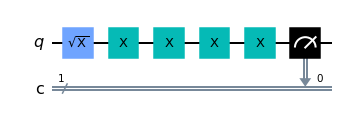

In [9]:
amp_cal.circuits()[5].draw(output="mpl")

In [10]:
data_over = amp_cal.run().block_for_results()

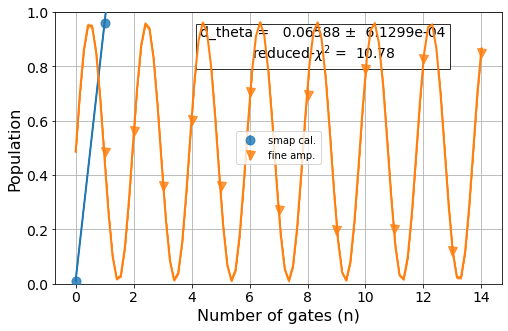

In [11]:
data_over.figure(0)

In [12]:
print(data_over.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: 0.0659+/-0.0006
- χ²: 10.784179473739899
- quality: bad
- device_components: ['Q0']
- verified: False


In [13]:
dtheta = data_over.analysis_results("d_theta").value.nominal_value
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.066 rad.
Thus, scale the 0.1276+0.0000j pulse amplitude by 0.979 to obtain 0.12501+0.00000j.
Amplitude reported by the backend 0.1251+0.0000j.


In [14]:
data_over.analysis_results("d_theta").value

0.06587649660247813+/-0.000612985221651094

In [15]:
type(data_over.analysis_results("d_theta").value)
data_over.analysis_results("d_theta").value.error_components().items()

dict_items([(< amp = 0.0+/-0.6865439673585886 >, 0.00020474880695398878), (< base = 0.0+/-0.894737321523811 >, 0.00037370216118452906), (< d_theta = 0.0+/-1.3145731270476837 >, 0.00044065349509515)])

### Detecting an under-rotated pulse

In [16]:
pulse_amp = ideal_amp*0.98
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as x_under:
    pulse.play(pulse.Drag(x_pulse.duration, pulse_amp, x_pulse.sigma, x_pulse.beta), d0)
    
inst_map.add("x", (qubit,), x_under)

In [17]:
amp_cal = FineXAmplitude(qubit, backend=backend)
amp_cal.set_transpile_options(inst_map=inst_map)

In [18]:
data_under = amp_cal.run().block_for_results()

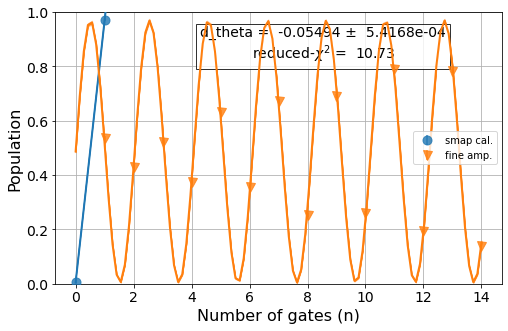

In [19]:
data_under.figure(0)

In [20]:
print(data_under.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: -0.0549+/-0.0005
- χ²: 10.726339129331024
- quality: bad
- device_components: ['Q0']
- verified: False


In [21]:
dtheta = data_under.analysis_results("d_theta").value.nominal_value
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of -0.055 rad.
Thus, scale the 0.1226+0.0000j pulse amplitude by 1.018 to obtain 0.12481+0.00000j.
Amplitude reported by the backend 0.1251+0.0000j.


### Analyzing a $\frac{\pi}{2}$ pulse

We now consider the $\frac{\pi}{2}$ rotation. Note that in this case we do not need to add a $\frac{\pi}{2}$ rotation to the circuits.

In [22]:
# restore the x_pulse
inst_map.add("x", (qubit,), backend.defaults().instruction_schedule_map.get('x', (qubit,)))

In [23]:
amp_cal = FineSXAmplitude(qubit, backend)
amp_cal.set_transpile_options(inst_map=inst_map)

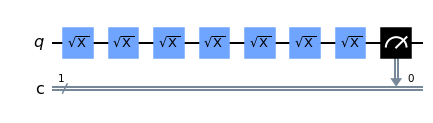

In [24]:
amp_cal.circuits()[5].draw(output="mpl")

In [25]:
data_x90p = amp_cal.run().block_for_results()

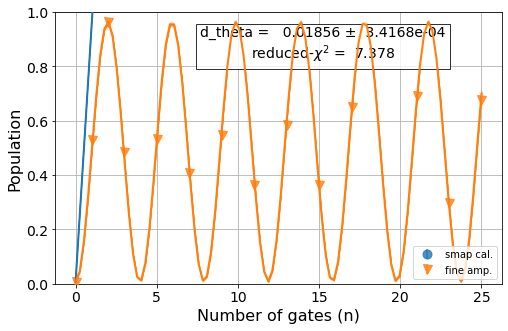

In [26]:
data_x90p.figure(0)

In [27]:
print(data_x90p.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: 0.01856+/-0.00034
- χ²: 7.378251675075845
- quality: bad
- device_components: ['Q0']
- verified: False


In [28]:
sx = backend.defaults().instruction_schedule_map.get('sx', (qubit,))
sx_ideal_amp = sx.instructions[0][1].pulse.amp

target_angle = np.pi / 2
dtheta = data_x90p.analysis_results("d_theta").value.nominal_value
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {sx_pulse.amp:.4f} pulse amplitude by {scale:.3f} to obtain {sx_pulse.amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of 0.019 rad.
Thus, scale the 0.0626+0.0000j pulse amplitude by 0.988 to obtain 0.06183+0.00000j.
Amplitude reported by the backend 0.0619+0.0014j.


Let's rerun this calibration using the updated value of the amplitude of the $\frac{\pi}{2}$ pulse.

In [29]:
pulse_amp = sx_pulse.amp*scale

with pulse.build(backend=backend, name="sx") as sx_new:
    pulse.play(pulse.Drag(x_pulse.duration, pulse_amp, x_pulse.sigma, x_pulse.beta), d0)
    
inst_map.add("sx", (qubit,), sx_new)

In [30]:
data_x90p = amp_cal.run().block_for_results()

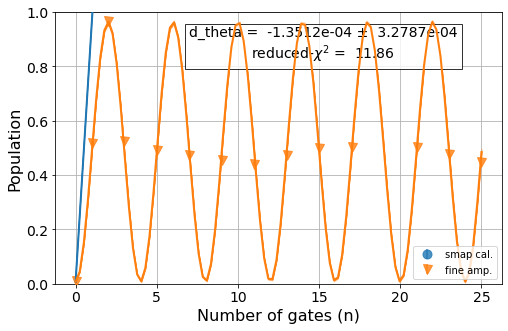

In [31]:
data_x90p.figure(0)

In [32]:
print(data_x90p.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: -0.00014+/-0.00033
- χ²: 11.859956619057801
- quality: bad
- device_components: ['Q0']
- verified: False


In [33]:
dtheta = data_x90p.analysis_results("d_theta").value.nominal_value
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of -0.000 rad.
Thus, scale the 0.0618+0.0000j pulse amplitude by 1.000 to obtain 0.06184+0.00000j.
Amplitude reported by the backend 0.0619+0.0014j.


## Fine DRAG Calibrations

In [34]:
from qiskit_experiments.library import FineXDrag

In [35]:
ideal_beta = x_pulse.beta
print(f"The reported beta of the X pulse is {ideal_beta:.4f}.")

The reported beta of the X pulse is 0.5778.


In [36]:
pulse_beta = ideal_beta*1.25
target_angle = np.pi

with pulse.build(backend=backend, name="x") as x_over:
    pulse.play(pulse.Drag(x_pulse.duration, x_pulse.amp, x_pulse.sigma, pulse_beta), d0)
    
inst_map.add("x", (qubit,), x_over)

In [37]:
drag_cal = FineXDrag(qubit, backend)
drag_cal.set_transpile_options(inst_map=inst_map)

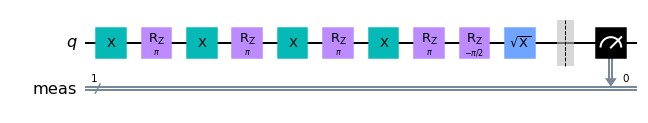

In [38]:
drag_cal.circuits()[2].draw("mpl")

In [39]:
data_drag_x = drag_cal.run().block_for_results()

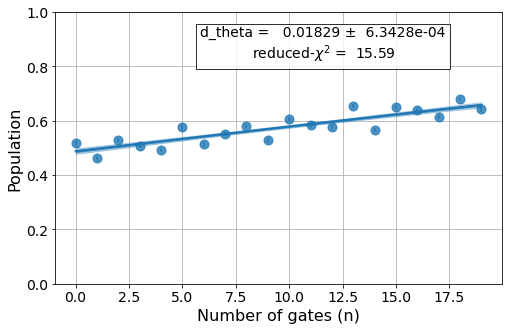

In [40]:
data_drag_x.figure(0)

In [41]:
print(data_drag_x.analysis_results(0))

DbAnalysisResultV1
- name: @Parameters_ErrorAmplificationAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_ping_pong(x) = amp / 2 * cos((d_theta + angle_per_gate) * x - phase_offset)...
 - success: True
 - number of function evals: 5
 - degree of freedom: 18
 - chi-square: 280.5784888308306
 - reduced chi-square: 15.587693823935034
 - Akaike info crit.: 56.82242459691683
 - Bayesian info crit.: 58.81388914402481
 - init params:
  * amp = 1.0
  * d_theta = -0.002099475131217199
  * angle_per_gate = 0.0
  * phase_offset = 1.5707963267948966
  * base = 0.5702324418895276
 - fit params:
  * amp = 1.0 ± 0.0
  * d_theta = 0.018293414074679614 ± 0.000634280880915364
  * angle_per_gate = 0.0 ± 0.0
  * phase_offset = 1.5707963267948966 ± 0.0
  * base = 0.488031917250596 ± 0.0034422870121584887
 - correlations:
  * (d_theta, base) = -0.863817956807257
- quality: bad
- device_components: ['Q0']
- verified: False


In [42]:
data_drag_x.analysis_results("d_theta").value.nominal_value

0.018293414074679614

In [43]:
dtheta = data_drag_x.analysis_results("d_theta").value.nominal_value

ddelta = -0.25 * np.sqrt(np.pi) * dtheta * x_pulse.sigma / ((target_angle**2) / 4)

print(f"Adjust β={pulse_beta:.3f} by ddelta={ddelta:.3f} to get {ddelta + pulse_beta:.3f} as new β.")
print(f"The backend reports β={x_pulse.beta:.3f}")

Adjust β=0.722 by ddelta=-0.131 to get 0.591 as new β.
The backend reports β=0.578


## Half angle calibrations

Phase errors imply that it is possible for the `sx` and `x` pulse to be misaligned. This can occure, for example, due to non-linearities in the mixer skew. The half angle experiment allows us to measure such issues.

In [44]:
from qiskit_experiments.library import HalfAngle

In [45]:
hac = HalfAngle(qubit, backend)
hac.set_transpile_options(inst_map=inst_map)

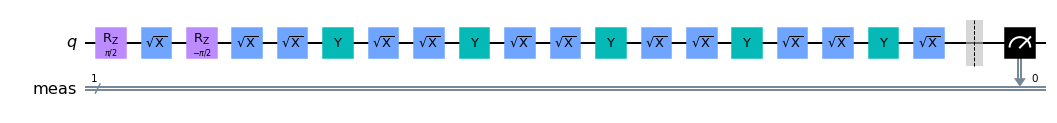

In [46]:
hac.circuits()[5].draw("mpl")

In [47]:
exp_data = hac.run().block_for_results()

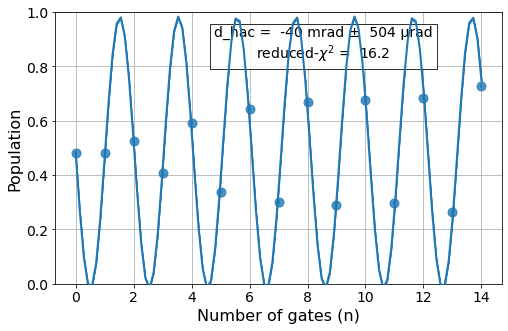

In [48]:
exp_data.figure(0)

In [49]:
print(exp_data.analysis_results(0))

DbAnalysisResultV1
- name: @Parameters_ErrorAmplificationAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_ping_pong(x) = amp / 2 * cos((d_theta + angle_per_gate) * x - phase_offset)...
 - success: True
 - number of function evals: 6
 - degree of freedom: 13
 - chi-square: 210.55424787065894
 - reduced chi-square: 16.196480605435305
 - Akaike info crit.: 43.62539692627212
 - Bayesian info crit.: 45.04149732847654
 - init params:
  * amp = 1.0
  * d_theta = 0.05956844122302759
  * angle_per_gate = 3.141592653589793
  * phase_offset = -1.5707963267948966
  * base = 0.49637590602349413
 - fit params:
  * amp = 1.0 ± 0.0
  * d_theta = -0.03998856226373016 ± 0.0005035045653885957
  * angle_per_gate = 3.141592653589793 ± 0.0
  * phase_offset = -1.5707963267948966 ± 0.0
  * base = 0.48289092268816736 ± 0.001926192333918246
 - correlations:
  * (d_theta, base) = 0.03602600187104871
- quality: bad
- device_components: ['Q0']
- verified: False


In [50]:
dhac = exp_data.analysis_results("d_hac").value.nominal_value

In [51]:
sx = backend.defaults().instruction_schedule_map.get('sx', (qubit,))
sx_amp = sx.instructions[0][1].pulse.amp

print(f"Adjust the phase of {np.angle(sx_pulse.amp)} of the sx pulse by {-dhac/2:.3f} rad.")
print(f"The backend reports an angle of {np.angle(sx_amp):.3f} for the sx pulse.")

Adjust the phase of 0.0 of the sx pulse by 0.020 rad.
The backend reports an angle of 0.022 for the sx pulse.


In [52]:
import qiskit.tools.jupyter
%qiskit_copyright